## Deep Convolutional Generative Adversarial Neural Network (DCGAN)

importing modules and mnist handwriting dataset from keras

In [2]:
import numpy as np
from keras.datasets import mnist
import imageio
import glob
import shutil
import os
import matplotlib.pyplot as plt
from tqdm import tqdm,tqdm_notebook,trange
import keras.backend as K
from IPython import display
from keras.models import Sequential,Model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense,Convolution2D,BatchNormalization,UpSampling2D,MaxPooling2D,Activation,Flatten,Reshape,Input

Using TensorFlow backend.


Reshaping Data to add Color Channel and Rescaling from [0-255] => [0-1]

In [2]:
(X_train,Y_train),(X_test,Y_test)=mnist.load_data()
X_train=X_train.reshape(X_train.shape[:]+tuple([1]))
X_train=X_train.astype("float32")
X_train/=255

In [3]:
print(X_train.shape)
print(Y_train.shape)

(60000, 28, 28, 1)
(60000,)


Building Generator

In [4]:
G=Sequential([
        Dense(7*7*128,input_dim=100),
        BatchNormalization(),
        Reshape((7,7,128)),
        LeakyReLU(),
        UpSampling2D(),
        Convolution2D(64,3,padding="same"),
        UpSampling2D(),
        Convolution2D(1,3,padding="same"),
        Activation("sigmoid")
    ])


In [5]:
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 64)        0         
__________

Building Discriminator

In [6]:
D=Sequential([
        Convolution2D(64,3,strides=(2,2),input_shape=[28,28,1]),
        MaxPooling2D(),
        LeakyReLU(0.2),
        Convolution2D(32,3,strides=(2,2)),
        MaxPooling2D(),
        LeakyReLU(0.2),
        Flatten(),
        Dense(1),
        Activation("sigmoid")
    ])

In [7]:
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 32)          18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
__________

In [8]:
G.compile(loss="binary_crossentropy",optimizer="adam")
D.compile(loss="binary_crossentropy",optimizer="adam")

In [9]:


D.trainable=False
I=Input(shape=[100])
g=G(I)
d=D(g)
adv=Model(inputs=[I],outputs=[d])

In [10]:
adv.summary()
adv.compile(loss="binary_crossentropy",optimizer="adam")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         732929    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 19137     
Total params: 752,066
Trainable params: 720,385
Non-trainable params: 31,681
_________________________________________________________________


In [11]:
# Removing Frames Directory and restarting the process of Saving Frames
try:
    shutil.rmtree("frames")
except FileNotFoundError:
    pass
os.mkdir("frames")
os.chdir("frames")

Training Started

In [ ]:

epoch=1 # Increase the epoch count to ~10. I can't wait to see the results so reducing it to 1 
        #:3
batch_size=32
X=0
ganLoss=[]
discLoss=[]
X_train=X_train
for i in range(epoch):
    print("Epoch #{}: \n\n".format(i),end=" ")
    bar=tqdm_notebook(range(0,X_train.shape[0],batch_size))
    for j in bar:
        noise=np.random.rand(batch_size,100)
        real=X_train[np.random.randint(0,X_train.shape[0],size=batch_size)]
        pred=G.predict(noise,batch_size=batch_size)
        inp=np.concatenate((pred,real))
        op=np.array([0]*batch_size+[1]*batch_size)
        D.trainable=True
        dLoss=D.train_on_batch(inp,op)
        discLoss.append(dLoss)
        #print("\n\n\n\nDisc Training")
        #print("Adv Non: ",np.sum([K.count_params(p) for p in set(adv.non_trainable_weights)]))
        #print("Disc Non: ",np.sum([K.count_params(p) for p in set(D.non_trainable_weights)]))
        noise=np.random.rand(batch_size,100)
        op=np.array([1]*batch_size)
        D.trainable=False
        gLoss=adv.train_on_batch(noise,op)
        ganLoss.append(gLoss)
        fig=plt.figure(figsize=(4,4))
        p=G.predict(np.random.rand(16,100),batch_size=16)
        for i in range(p.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow(p[i].reshape(p[i].shape[0],p[i].shape[1]))
            plt.axis('off')
        plt.savefig("frame_{}.png".format(X))
        plt.close()
        X+=1
        #print("\n\n\n\nGAN training")
        #print("Adv Non: ",np.sum([K.count_params(p) for p in set(adv.non_trainable_weights)]))
        #print("Disc Non: ",np.sum([K.count_params(p) for p in set(D.non_trainable_weights)]))
        if not j%100:
            print("Gen Loss: {}\t Disc Loss: {}".format(gLoss,dLoss))

Epoch #0: 

 

Gen Loss: 0.7138351202011108	 Disc Loss: 0.6761742830276489
Gen Loss: 0.713944673538208	 Disc Loss: 0.6273180246353149
Gen Loss: 0.5791285037994385	 Disc Loss: 0.6382993459701538
Gen Loss: 0.6189805865287781	 Disc Loss: 0.6239538192749023
Gen Loss: 0.45851776003837585	 Disc Loss: 0.31669214367866516
Gen Loss: 0.6571049690246582	 Disc Loss: 0.5443524122238159
Gen Loss: 0.7482575178146362	 Disc Loss: 0.41451796889305115
Gen Loss: 0.7304292917251587	 Disc Loss: 0.41788822412490845
Gen Loss: 0.580478310585022	 Disc Loss: 0.5058743953704834
Gen Loss: 0.5793368220329285	 Disc Loss: 0.8594643473625183
Gen Loss: 0.9906033277511597	 Disc Loss: 0.41317254304885864
Gen Loss: 0.7285634279251099	 Disc Loss: 0.6413242220878601
Gen Loss: 0.6860966682434082	 Disc Loss: 0.671500563621521
Gen Loss: 0.7678042650222778	 Disc Loss: 0.5380929708480835
Gen Loss: 0.8476228713989258	 Disc Loss: 0.3659754693508148
Gen Loss: 1.1109087467193604	 Disc Loss: 0.33988869190216064
Gen Loss: 1.4453790187835693	 Disc Lo

In [3]:
os.chdir("frames")

In [4]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
    filenames = glob.glob('frame_*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

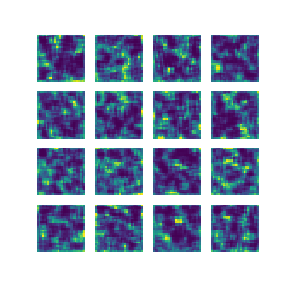

In [5]:
shutil.copy2("dcgan.gif","dcgan.gif.png")
display.Image(filename="dcgan.gif.png")